In [153]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
!pip install pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()

In [ ]:
df = spark.read.parquet('/content/drive/MyDrive/sf-airbnb-clean.parquet')

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Data Exploration

In [155]:
df.printSchema()

root
 |-- host_is_superhost: string (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- instant_bookable: string (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- neighbourhood_cleansed: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: double (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)
 |-- review_scores_accuracy: double (nullable = true)
 |-- review_scores_cleanliness: double (nullable = true)
 |-- review_scores_checkin: double (nullable = true)
 |-- review_scores_communication: double (nullable = true

In [ ]:
df.show(10,truncate=False)

+-----------------+---------------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+----+--------+--------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+-----+-----------+------------+-------+-----------------------+-------------------------+----------------------------+------------------------+------------------------------+-------------------------+----------------------+
|host_is_superhost|cancellation_policy        |instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude|longitude |property_type|room_type      |accommodates|bathrooms|bedrooms|beds|bed_type|minimum_nights|number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_sc

In [ ]:
#summary statistics of the dataframe
df_summary = df.summary()
df_summary.show()

+-------+-----------------+-------------------+----------------+-------------------------+----------------------+--------------------+--------------------+-------------+---------------+------------------+------------------+------------------+------------------+--------+------------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+------------------+-------------------+--------------------+--------------------+-----------------------+-------------------------+----------------------------+------------------------+------------------------------+-------------------------+----------------------+
|summary|host_is_superhost|cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|            latitude|           longitude|property_type|      room_type|      accommodates|         bathrooms|          bedrooms|              beds|bed

In [ ]:
df.cache()

DataFrame[host_is_superhost: string, cancellation_policy: string, instant_bookable: string, host_total_listings_count: double, neighbourhood_cleansed: string, latitude: double, longitude: double, property_type: string, room_type: string, accommodates: double, bathrooms: double, bedrooms: double, beds: double, bed_type: string, minimum_nights: double, number_of_reviews: double, review_scores_rating: double, review_scores_accuracy: double, review_scores_cleanliness: double, review_scores_checkin: double, review_scores_communication: double, review_scores_location: double, review_scores_value: double, price: double, bedrooms_na: double, bathrooms_na: double, beds_na: double, review_scores_rating_na: double, review_scores_accuracy_na: double, review_scores_cleanliness_na: double, review_scores_checkin_na: double, review_scores_communication_na: double, review_scores_location_na: double, review_scores_value_na: double]

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoder,FeatureHasher
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler ,StandardScaler
from pyspark.ml.regression import RandomForestRegressor


In [ ]:
df.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na']

In [ ]:
cols_to_keep = [col for col in df.columns if not col.endswith("na")]

df_dropped = df.select(*cols_to_keep)



In [ ]:
df_dropped.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price']

In [ ]:
#a list of all numeric features
numericCols = [k for k,v in df_dropped.dtypes if (v=='double' ) ]
numericCols

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price']

In [ ]:
#checking correlation
df_pandas=df_dropped.toPandas()
correlation_matrix=df_pandas[numericCols].corr()

In [ ]:
correlation_matrix['price'].head(15)

host_total_listings_count     -0.012935
latitude                       0.104869
longitude                      0.021325
accommodates                   0.372839
bathrooms                      0.183564
bedrooms                       0.360764
beds                           0.317993
minimum_nights                -0.032403
number_of_reviews             -0.096274
review_scores_rating           0.084402
review_scores_accuracy         0.046179
review_scores_cleanliness      0.079069
review_scores_checkin          0.019587
review_scores_communication    0.026654
review_scores_location         0.071245
Name: price, dtype: float64

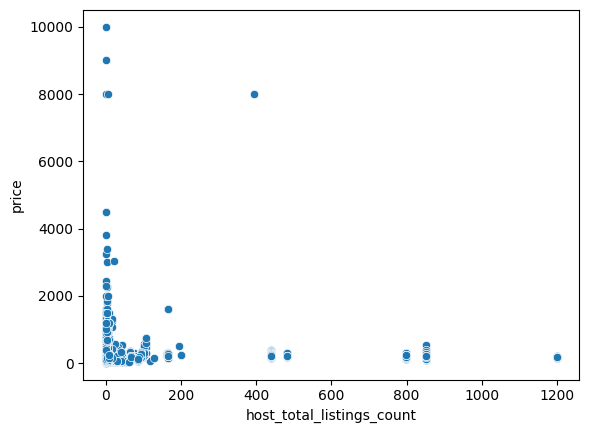

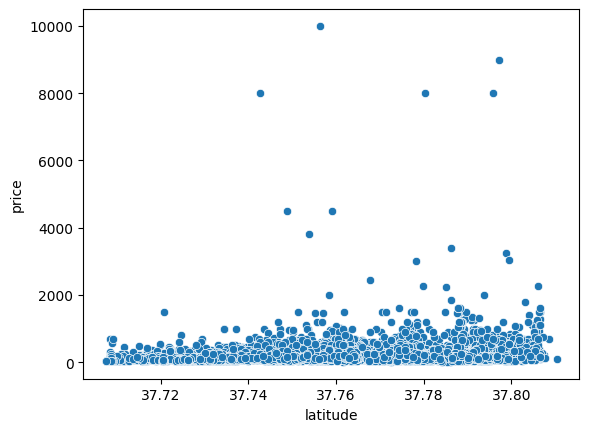

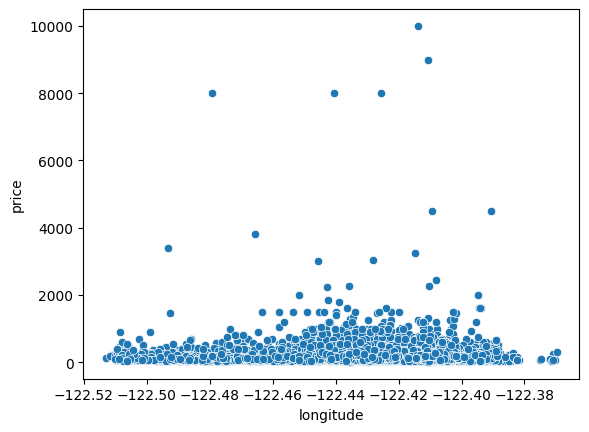

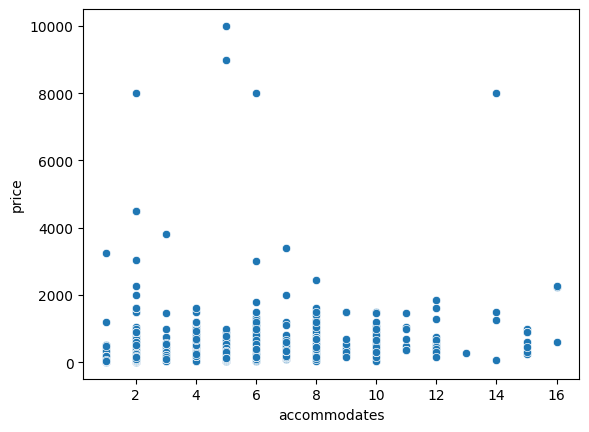

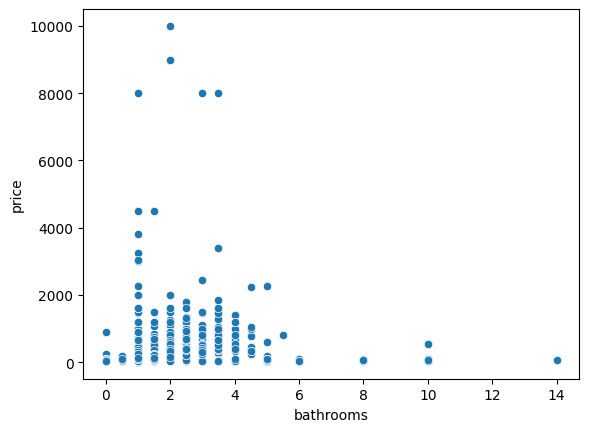

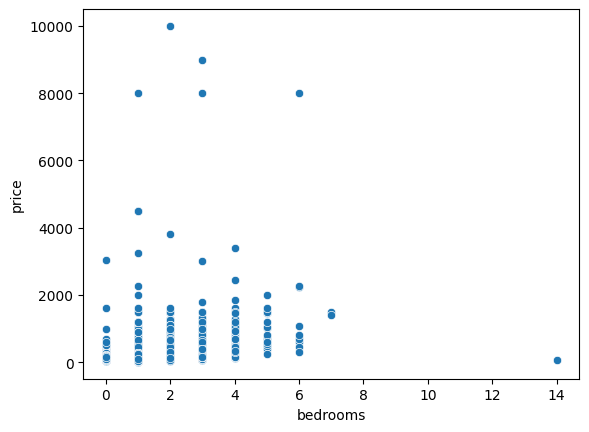

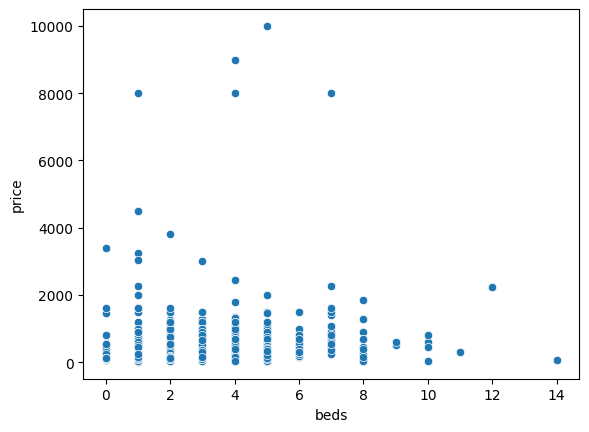

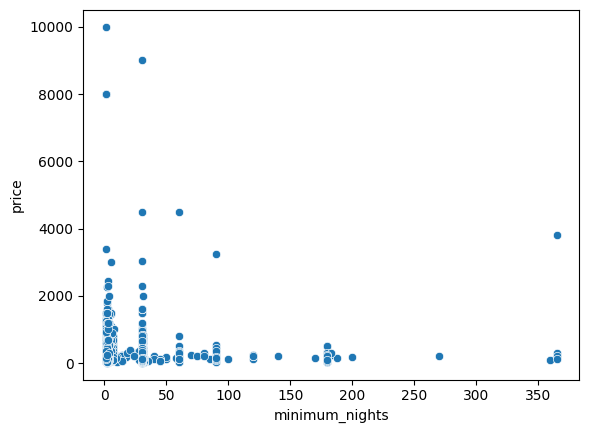

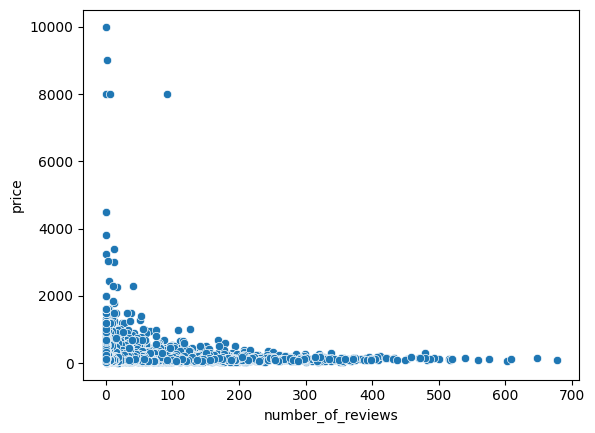

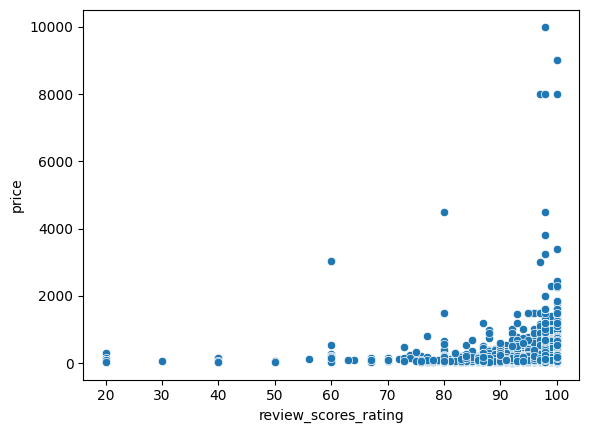

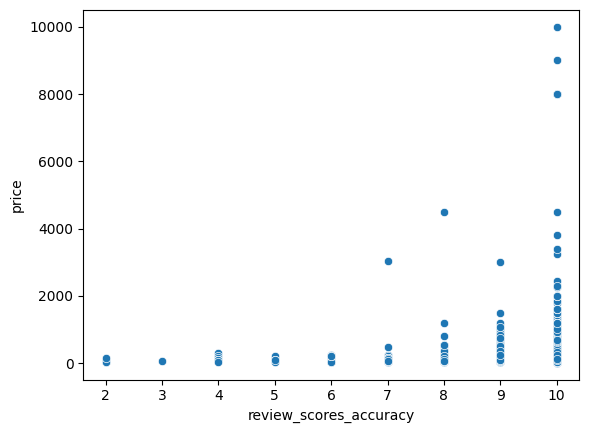

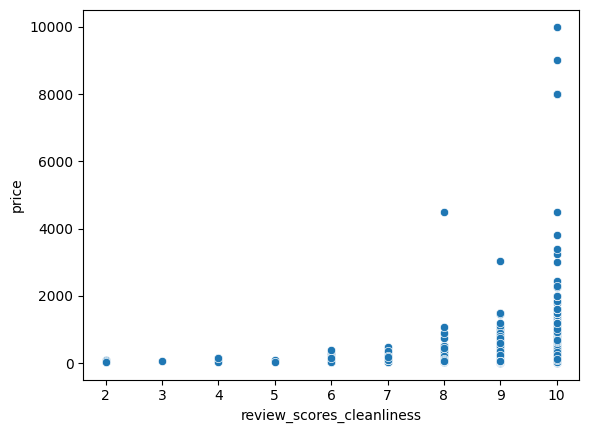

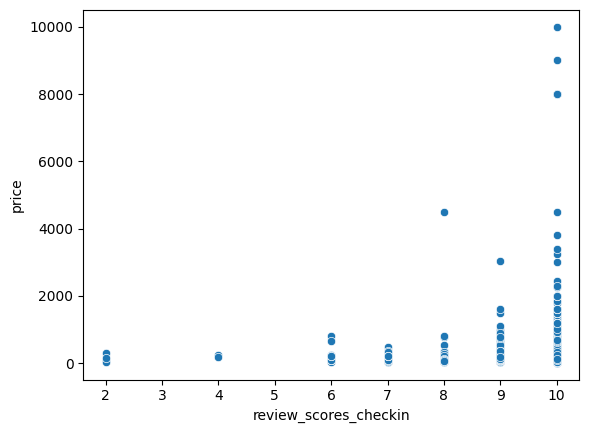

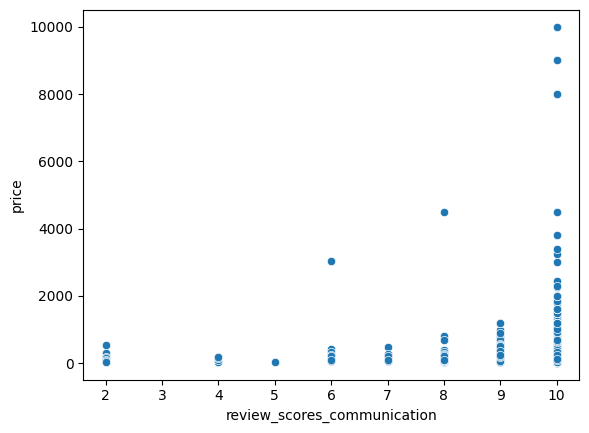

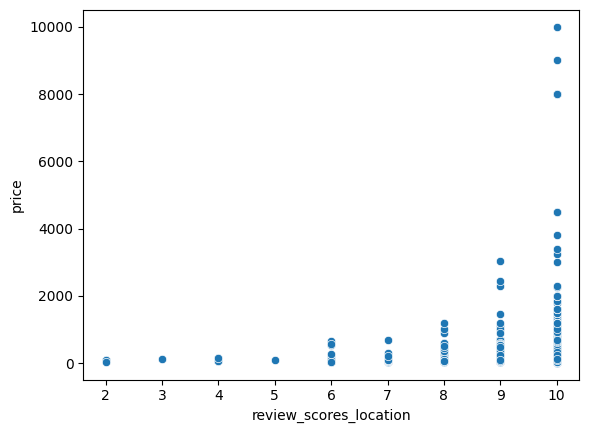

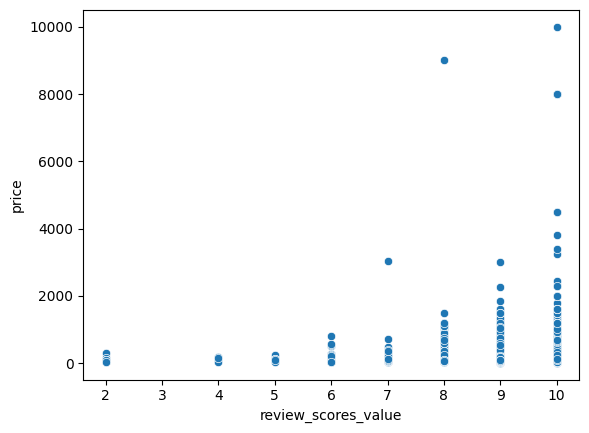

In [ ]:
#visulalizing relationships between price and other numeric features
for var in numericCols:
    if var!='price':
      sns.scatterplot(x=df_pandas[var], y=df_pandas['price'])
      plt.show()


In [ ]:
#finding distinct values for categorical featueres
stringCols = [k for k,v in df_dropped.dtypes if (v=='string')]
for col in stringCols:
  print(df_dropped.select(col).distinct().collect())
  print('\n')

[Row(host_is_superhost='f'), Row(host_is_superhost='t')]


[Row(cancellation_policy='flexible'), Row(cancellation_policy='super_strict_60'), Row(cancellation_policy='strict'), Row(cancellation_policy='super_strict_30'), Row(cancellation_policy='moderate'), Row(cancellation_policy='strict_14_with_grace_period')]


[Row(instant_bookable='f'), Row(instant_bookable='t')]


[Row(neighbourhood_cleansed='Inner Sunset'), Row(neighbourhood_cleansed='Haight Ashbury'), Row(neighbourhood_cleansed='Financial District'), Row(neighbourhood_cleansed='North Beach'), Row(neighbourhood_cleansed='Western Addition'), Row(neighbourhood_cleansed='Downtown/Civic Center'), Row(neighbourhood_cleansed='Bernal Heights'), Row(neighbourhood_cleansed='Lakeshore'), Row(neighbourhood_cleansed='Outer Sunset'), Row(neighbourhood_cleansed='Visitacion Valley'), Row(neighbourhood_cleansed='Inner Richmond'), Row(neighbourhood_cleansed='Nob Hill'), Row(neighbourhood_cleansed='Outer Richmond'), Row(neighbourhood_cleansed='Cro

A proposed idea for encoding categorical features

In [ ]:
#one hot
#host_is_superhost          instant_bookable
#ordinal
#cancellation_policy            room_type             bed_type
#target encoding
#neighbourhood_cleansed         property_type

In [ ]:
#from the visualization of the relationships between price and other numeric features , it's supposed that these transformation would help enhancing performance
df_new = df_dropped.withColumn('host_total_listings_count', exp(-df_dropped['host_total_listings_count']))\
                   .withColumn('beds', exp(-df_dropped['beds']))\
                   .withColumn('minimum_nights', exp(-df_dropped['minimum_nights']))\
                   .withColumn('number_of_reviews', exp(-df_dropped['number_of_reviews']))\
                   .withColumn('review_scores_rating', exp(df_dropped['review_scores_rating']))\
                   .withColumn('review_scores_accuracy', exp(df_dropped['review_scores_accuracy']))\
                   .withColumn('review_scores_cleanliness', exp(df_dropped['review_scores_cleanliness']))\
                   .withColumn('review_scores_checkin', exp(df_dropped['review_scores_checkin']))\
                   .withColumn('review_scores_communication', exp(df_dropped['review_scores_communication']))\
                   .withColumn('review_scores_location', exp(df_dropped['review_scores_location']))\
                   .withColumn('review_scores_value', exp(df_dropped['review_scores_value']))\
                   .withColumn('price', log(df_dropped['price']))



In [ ]:
#list of numeric features except for the target(price)
numericCols.remove('price')
numericCols

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

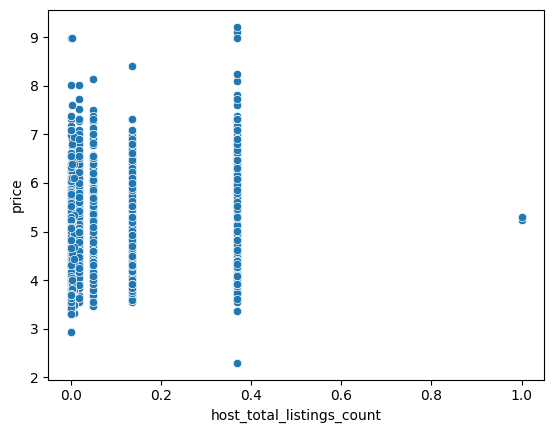

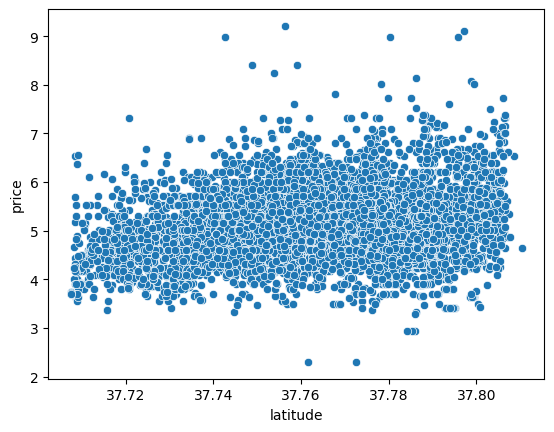

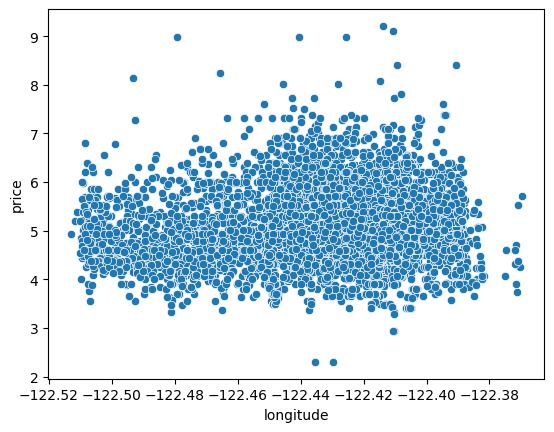

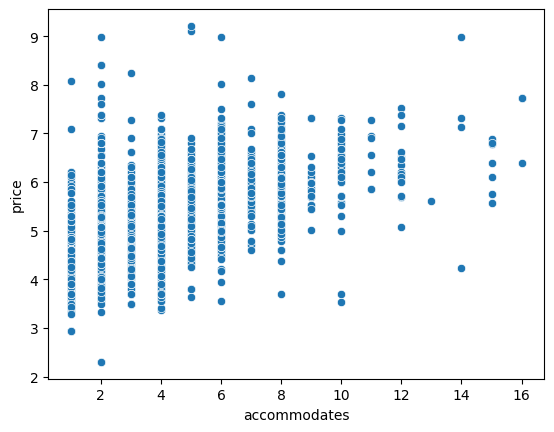

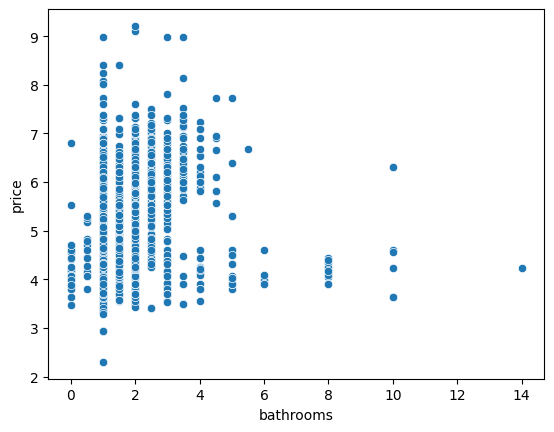

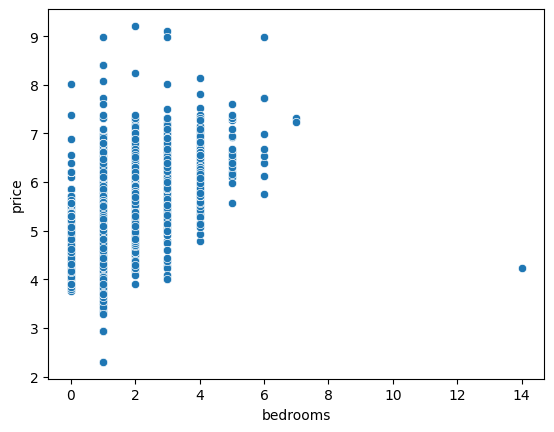

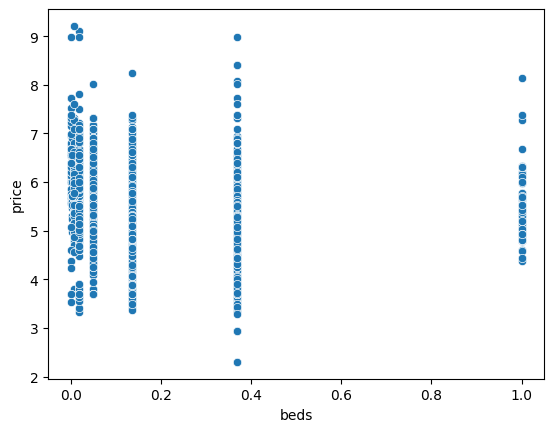

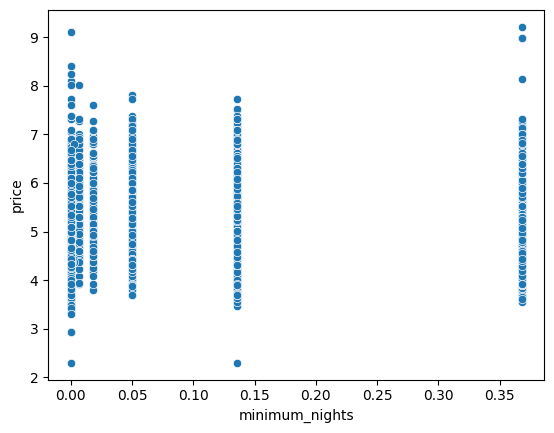

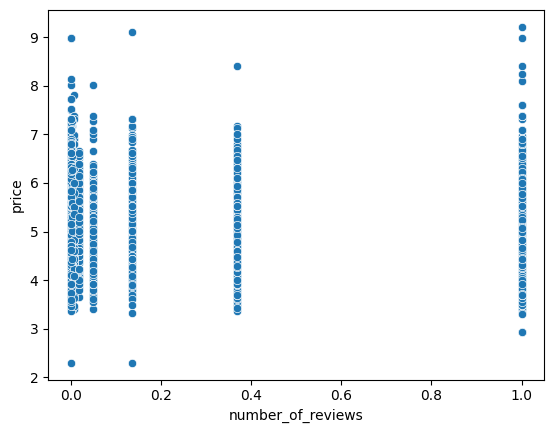

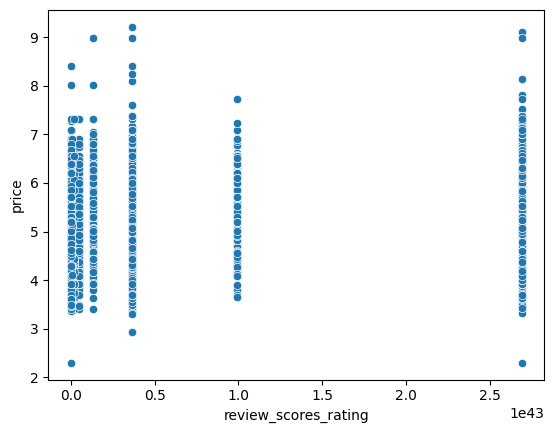

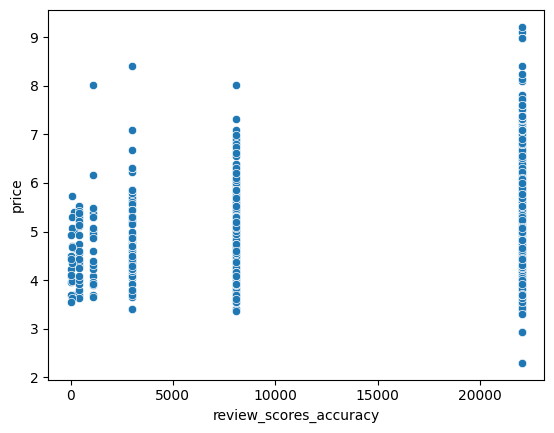

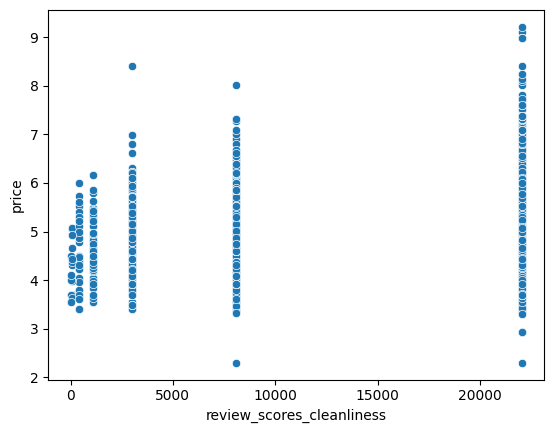

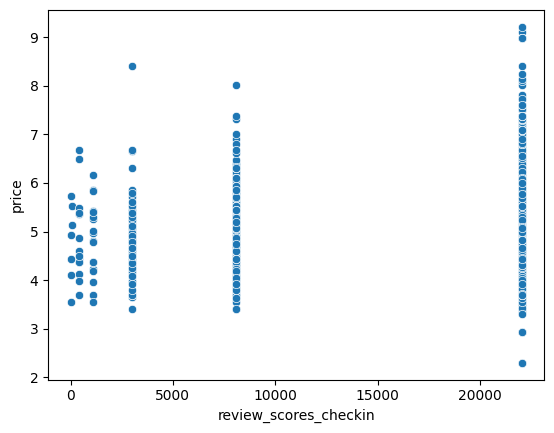

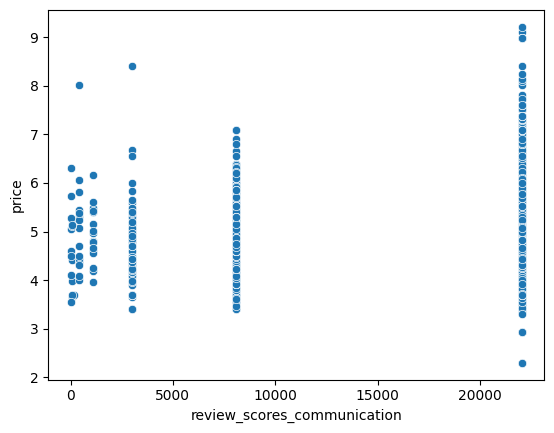

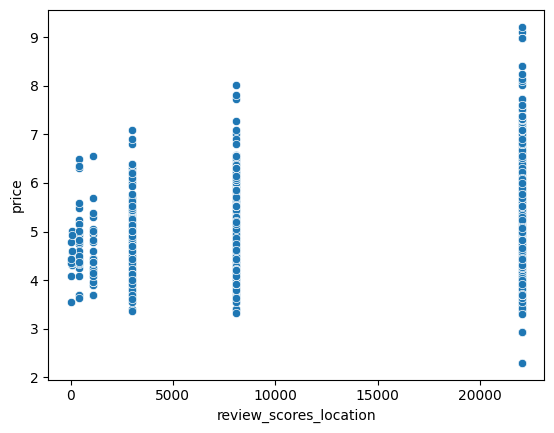

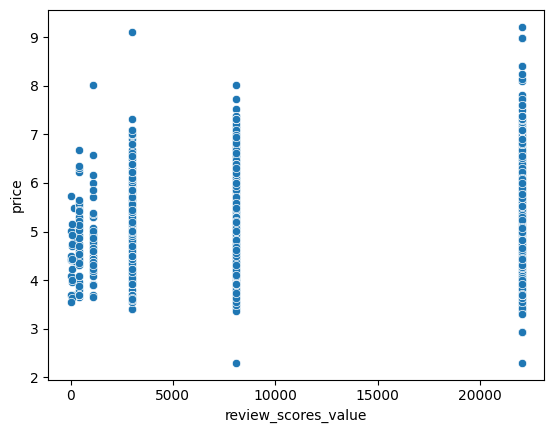

In [ ]:
#checking the relationships after transformation
df_pandas_new=df_new.toPandas()
for var in numericCols:

    sns.scatterplot(x=df_pandas_new[var], y=df_pandas_new['price'])
    plt.show()

In [ ]:
for var in numericCols:
  corr_coef, p_value = pearsonr(df_pandas[var], df_pandas['price'])
  print(f"{var}: correlation coefficient = {corr_coef}, p-value = {p_value}\n")



host_total_listings_count: correlation coefficient = -0.012935128800385687, p-value = 0.2742564652555442

latitude: correlation coefficient = 0.10486876914642113, p-value = 6.22507065813456e-19

longitude: correlation coefficient = 0.0213246657427645, p-value = 0.0714590328381443

accommodates: correlation coefficient = 0.3728393298793249, p-value = 1.651197867855093e-234

bathrooms: correlation coefficient = 0.18356398329503673, p-value = 3.437774234282449e-55

bedrooms: correlation coefficient = 0.3607643374975288, p-value = 1.291187083394754e-218

beds: correlation coefficient = 0.3179925614860468, p-value = 1.2467945209089007e-167

minimum_nights: correlation coefficient = -0.03240288649194685, p-value = 0.006155400997453774

number_of_reviews: correlation coefficient = -0.09627367461736341, p-value = 3.465121814532475e-16

review_scores_rating: correlation coefficient = 0.08440212912723814, p-value = 8.911131676152454e-13

review_scores_accuracy: correlation coefficient = 0.046179

In [ ]:
# train,test=df_new.randomSplit([0.8,0.2],seed=42)
# train.write.mode("overwrite").parquet('air_train')
# test.write.mode("overwrite").parquet('air_test')
#after splitting data to train and test , we save it so we can keep track of changes of performance on the same data since there is random partitioning which can't be controlled through the seed
traindf=spark.read.parquet('/content/drive/MyDrive/air_train',header=True,inferSchema=True)
testdf=spark.read.parquet('/content/drive/MyDrive/air_test',header=True,inferSchema=True)

Testing whether numeric features have equal means in train and test

In [ ]:
from scipy.stats import ttest_ind_from_stats
import pyspark.sql.functions as F

results = {}

train_stats = traindf.select(
    *[F.mean(col).alias(f"{col}_mean") for col in numericCols],
    *[F.stddev(col).alias(f"{col}_stddev") for col in numericCols],
    *[F.count(col).alias(f"{col}_count") for col in numericCols]
).collect()[0]

test_stats = testdf.select(
    *[F.mean(col).alias(f"{col}_mean") for col in numericCols],
    *[F.stddev(col).alias(f"{col}_stddev") for col in numericCols],
    *[F.count(col).alias(f"{col}_count") for col in numericCols]
).collect()[0]

for col in numericCols:
    train_mean = train_stats[f"{col}_mean"]
    train_stddev = train_stats[f"{col}_stddev"]
    train_count = train_stats[f"{col}_count"]

    test_mean = test_stats[f"{col}_mean"]
    test_stddev = test_stats[f"{col}_stddev"]
    test_count = test_stats[f"{col}_count"]

    t_stat, p_value = ttest_ind_from_stats(
        mean1=train_mean, std1=train_stddev, nobs1=train_count,
        mean2=test_mean, std2=test_stddev, nobs2=test_count,
        equal_var=False
    )

    results[col] = {"t_stat": t_stat, "p_value": p_value}
results = {}

for col in numericCols:
    train_mean = train_stats[f"{col}_mean"]
    train_stddev = train_stats[f"{col}_stddev"]
    train_count = train_stats[f"{col}_count"]

    test_mean = test_stats[f"{col}_mean"]
    test_stddev = test_stats[f"{col}_stddev"]
    test_count = test_stats[f"{col}_count"]

    t_stat, p_value = ttest_ind_from_stats(
        mean1=train_mean, std1=train_stddev, nobs1=train_count,
        mean2=test_mean, std2=test_stddev, nobs2=test_count,
        equal_var=False
    )

    results[col] = {"t_stat": t_stat, "p_value": p_value}

for col, res in results.items():
    print(f"Feature: {col}, t-statistic: {res['t_stat']}, p-value: {res['p_value']}")


Feature: host_total_listings_count, t-statistic: 0.03443002002656482, p-value: 0.9725375988194198
Feature: latitude, t-statistic: 1.173650196292332, p-value: 0.24067258304796818
Feature: longitude, t-statistic: -0.34007845732349556, p-value: 0.7338323019347261
Feature: accommodates, t-statistic: 1.9281207997800425, p-value: 0.0539706745429909
Feature: bathrooms, t-statistic: 1.8728104138180144, p-value: 0.061230166084867595
Feature: bedrooms, t-statistic: 0.25301557238616035, p-value: 0.8002824845113463
Feature: beds, t-statistic: -1.8322159197466525, p-value: 0.06706482297457321
Feature: minimum_nights, t-statistic: -0.7530058112927897, p-value: 0.4515335560622198
Feature: number_of_reviews, t-statistic: 1.0443148802229276, p-value: 0.29646087301159074
Feature: review_scores_rating, t-statistic: 1.2854448572486292, p-value: 0.19878051572494884
Feature: review_scores_accuracy, t-statistic: 0.934736648416594, p-value: 0.35003630264180363
Feature: review_scores_cleanliness, t-statistic: 

In [ ]:
stringCols = [k for k,v in df_dropped.dtypes if (v=='string')]
for col in stringCols:
  print(df_dropped.select(col).distinct().collect())
  print('\n')

[Row(host_is_superhost='f'), Row(host_is_superhost='t')]


[Row(cancellation_policy='flexible'), Row(cancellation_policy='super_strict_60'), Row(cancellation_policy='strict'), Row(cancellation_policy='super_strict_30'), Row(cancellation_policy='moderate'), Row(cancellation_policy='strict_14_with_grace_period')]


[Row(instant_bookable='f'), Row(instant_bookable='t')]


[Row(neighbourhood_cleansed='Inner Sunset'), Row(neighbourhood_cleansed='Haight Ashbury'), Row(neighbourhood_cleansed='Financial District'), Row(neighbourhood_cleansed='North Beach'), Row(neighbourhood_cleansed='Western Addition'), Row(neighbourhood_cleansed='Downtown/Civic Center'), Row(neighbourhood_cleansed='Bernal Heights'), Row(neighbourhood_cleansed='Lakeshore'), Row(neighbourhood_cleansed='Outer Sunset'), Row(neighbourhood_cleansed='Visitacion Valley'), Row(neighbourhood_cleansed='Inner Richmond'), Row(neighbourhood_cleansed='Nob Hill'), Row(neighbourhood_cleansed='Outer Richmond'), Row(neighbourhood_cleansed='Cro

In [ ]:
#to make sure that same categories exist in the whole dataset and the train set
stringCols = [k for k,v in traindf.dtypes if (v=='string')]
for col in stringCols:
  print(traindf.select(col).distinct().collect())
  print('\n')

[Row(host_is_superhost='f'), Row(host_is_superhost='t')]


[Row(cancellation_policy='flexible'), Row(cancellation_policy='super_strict_60'), Row(cancellation_policy='strict'), Row(cancellation_policy='super_strict_30'), Row(cancellation_policy='moderate'), Row(cancellation_policy='strict_14_with_grace_period')]


[Row(instant_bookable='f'), Row(instant_bookable='t')]


[Row(neighbourhood_cleansed='Inner Sunset'), Row(neighbourhood_cleansed='Haight Ashbury'), Row(neighbourhood_cleansed='Financial District'), Row(neighbourhood_cleansed='North Beach'), Row(neighbourhood_cleansed='Western Addition'), Row(neighbourhood_cleansed='Downtown/Civic Center'), Row(neighbourhood_cleansed='Bernal Heights'), Row(neighbourhood_cleansed='Lakeshore'), Row(neighbourhood_cleansed='Outer Sunset'), Row(neighbourhood_cleansed='Visitacion Valley'), Row(neighbourhood_cleansed='Inner Richmond'), Row(neighbourhood_cleansed='Nob Hill'), Row(neighbourhood_cleansed='Outer Richmond'), Row(neighbourhood_cleansed='Cro

In [ ]:
traindf.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price']

# **Model Building**

In [157]:
dtypes=traindf.dtypes
stringCols = [k for k,v in dtypes if v=='string']
stringColOut = [k+'_Index' for k,v in dtypes if v=='string']

OHEcols=['host_is_superhost' ,  'instant_bookable'  ,'cancellation_policy','room_type','bed_type','neighbourhood_cleansed' ,  'property_type' ]
OHEoutCol = ['host_is_superhost_OHE'   ,'instant_bookable_OHE'  ,'cancellation_policy_OHE','room_type_OHE','bed_type_OHE','neighbourhood_cleansed_OHE','property_type_OHE']


allcols=OHEoutCol+numericCols

In [158]:
allcols

['host_is_superhost_OHE',
 'instant_bookable_OHE',
 'cancellation_policy_OHE',
 'room_type_OHE',
 'bed_type_OHE',
 'neighbourhood_cleansed_OHE',
 'property_type_OHE',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [159]:
StrInd = StringIndexer(inputCols=stringCols,outputCols=stringColOut,handleInvalid='keep')
OHE = OneHotEncoder(inputCols=stringColOut,outputCols=OHEoutCol)

vecAssemb = VectorAssembler(inputCols=allcols,outputCol='features')

#standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

## Linear Regression

In [ ]:
#create the linear regression object
lr = LinearRegression(featuresCol='scaled_features',labelCol='price',predictionCol='prediction')
#define the stages for the pipeline
stages = [StrInd,OHE,vecAssemb,scaler,lr]
#creating the pipeline object
pl = Pipeline(stages=stages)
#fitting the pipeline to the training data
pl_Model = pl.fit(traindf)
pred_train = pl_Model.transform(traindf)
#finally transform on the test data
pred_test = pl_Model.transform(testdf)

Evaluating model on price (normal scale)

In [ ]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))

Evaluating model on log_price

In [ ]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')


R_2 for train data 0.21780109805542802

R_2 for test data -0.25044572013908883


## Lasso Regression

In [ ]:
#create the linear regression object
lr = LinearRegression(featuresCol='features',labelCol='price',predictionCol='prediction',regParam = 0.9)
#define the stages for the pipeline
stages = [StrInd,OHE,vecAssemb,lr]
#creating the pipeline object
pl = Pipeline(stages=stages)
#fitting the pipeline to the training data
pl_Model = pl.fit(traindf)
pred_train = pl_Model.transform(traindf)
#finally transform on the test data
pred_test = pl_Model.transform(testdf)

In [ ]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')


R_2 for train data 0.12603298364567517

R_2 for test data 0.35949163432694564


## GridSearch for regParam

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
lr = LinearRegression(featuresCol='features',labelCol='price',predictionCol='prediction2', elasticNetParam=1)


In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]) \
    .build()

evaluator = RegressionEvaluator(predictionCol="prediction2", labelCol= "price", metricName="r2")
cross_validator = CrossValidator(estimator=lr,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)

cv_model = cross_validator.fit(pred_train)
lasso_model = cv_model.bestModel

In [ ]:
lasso_model

LinearRegressionModel: uid=LinearRegression_edd3387b563a, numFeatures=96

In [ ]:
pred_train = lasso_model.transform(pred_train)
pred_test = lasso_model.transform(pred_test)

In [ ]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')


R_2 for train data 0.12603298364567517

R_2 for test data 0.35949163432694564


## Random Forest

In [160]:
#create the random forest object
rf=RandomForestRegressor(featuresCol='features',labelCol='price',predictionCol='prediction',numTrees=1000)
#define the stages for the pipeline
stages = [StrInd,OHE,vecAssemb,rf]
#creating the pipeline object
pl = Pipeline(stages=stages)
#fitting the pipeline to the training data
pl_Model = pl.fit(traindf)
pred_train = pl_Model.transform(traindf)
#finally transform on the test data
pred_test = pl_Model.transform(testdf)

In [161]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')


R_2 for train data 0.17345271590825773

R_2 for test data 0.4781207529603596


In [164]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.622555547337185

R_2 for test data 0.6415114688272402


In [ ]:
from pyspark.sql.functions import col



Function to extract new features

In [ ]:
def add_features(df, numericCols):
    for i in range(len(numericCols)):
        col1 = numericCols[i]
        #square
        df = df.withColumn(f'{col1}_square', col(col1)**2)

        #cube
        df = df.withColumn(f'{col1}_cube', col(col1)**3)


        for j in range(i + 1, len(numericCols)):
            col2 = numericCols[j]

            #addition
            df = df.withColumn(f'{col1}_plus_{col2}', col(col1) + col(col2))

            #multiplication

            df = df.withColumn(f'{col1}_times_{col2}', col(col1) * col(col2))

    return df

In [ ]:
traindf_with_features = add_features(traindf, numericCols)

testdf_with_features = add_features(testdf, numericCols)

In [165]:

dtypes=traindf.dtypes
stringCols = [k for k,v in dtypes if v=='string']
stringColOut = [k+'_Index' for k,v in dtypes if v=='string']

OHEoutCol = ['host_is_superhost_OHE'   ,'instant_bookable_OHE'  ,'cancellation_policy_OHE','room_type_OHE','bed_type_OHE','neighbourhood_cleansed_OHE','property_type_OHE']
numericColsnew=[k for k,v in traindf_with_features.dtypes if (v=='double' ) ]
numericColsnew.remove('price')

allcolsnew=OHEoutCol+numericColsnew

In [167]:
print(allcolsnew)
print(len(allcolsnew))

['host_is_superhost_OHE', 'instant_bookable_OHE', 'cancellation_policy_OHE', 'room_type_OHE', 'bed_type_OHE', 'neighbourhood_cleansed_OHE', 'property_type_OHE', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_total_listings_count_square', 'host_total_listings_count_cube', 'host_total_listings_count_plus_latitude', 'host_total_listings_count_times_latitude', 'host_total_listings_count_plus_longitude', 'host_total_listings_count_times_longitude', 'host_total_listings_count_plus_accommodates', 'host_total_listings_count_times_accommodates', 'host_total_listings_count_plus_bathrooms', 'host_total_listings_count_times_bathrooms', 'host_total_listings_count_plus_bedrooms', 'host_total_listings_count_times_bedroom

## Linear Regression with new features

In [ ]:
StrInd = StringIndexer(inputCols=stringCols,outputCols=stringColOut,handleInvalid='keep')
OHE = OneHotEncoder(inputCols=stringColOut,outputCols=OHEoutCol,handleInvalid='keep')

vecAssemb = VectorAssembler(inputCols=allcolsnew,outputCol='features',handleInvalid='keep')

#standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [ ]:
#create the linear regression object
lr = LinearRegression(featuresCol='features',labelCol='price',predictionCol='prediction',regParam = 0.9)
#define the stages for the pipeline
stages = [StrInd,OHE,vecAssemb,scaler,lr]
#creating the pipeline object
pl = Pipeline(stages=stages)
#fitting the pipeline to the training data
pl_Model = pl.fit(traindf_with_features)
pred_train = pl_Model.transform(traindf_with_features)
#finally transform on the test data
pred_test = pl_Model.transform(testdf_with_features)

In [ ]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')


R_2 for train data 0.20807191546061887

R_2 for test data -1.0972419953372365


In [168]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.622555547337185

R_2 for test data 0.6415114688272402


## Random Forest with new features

In [169]:
#create the random forest object
rf=RandomForestRegressor(featuresCol='features',labelCol='price',predictionCol='prediction',numTrees=1000)
#define the stages for the pipeline
stages = [StrInd,OHE,vecAssemb,rf]
#creating the pipeline object
pl = Pipeline(stages=stages)
#fitting the pipeline to the training data
pl_Model = pl.fit(traindf_with_features)
pred_train = pl_Model.transform(traindf_with_features)
#finally transform on the test data
pred_test = pl_Model.transform(testdf_with_features)

In [170]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.17345271590825773

R_2 for test data 0.4781207529603596


In [171]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.622555547337185

R_2 for test data 0.6415114688272402


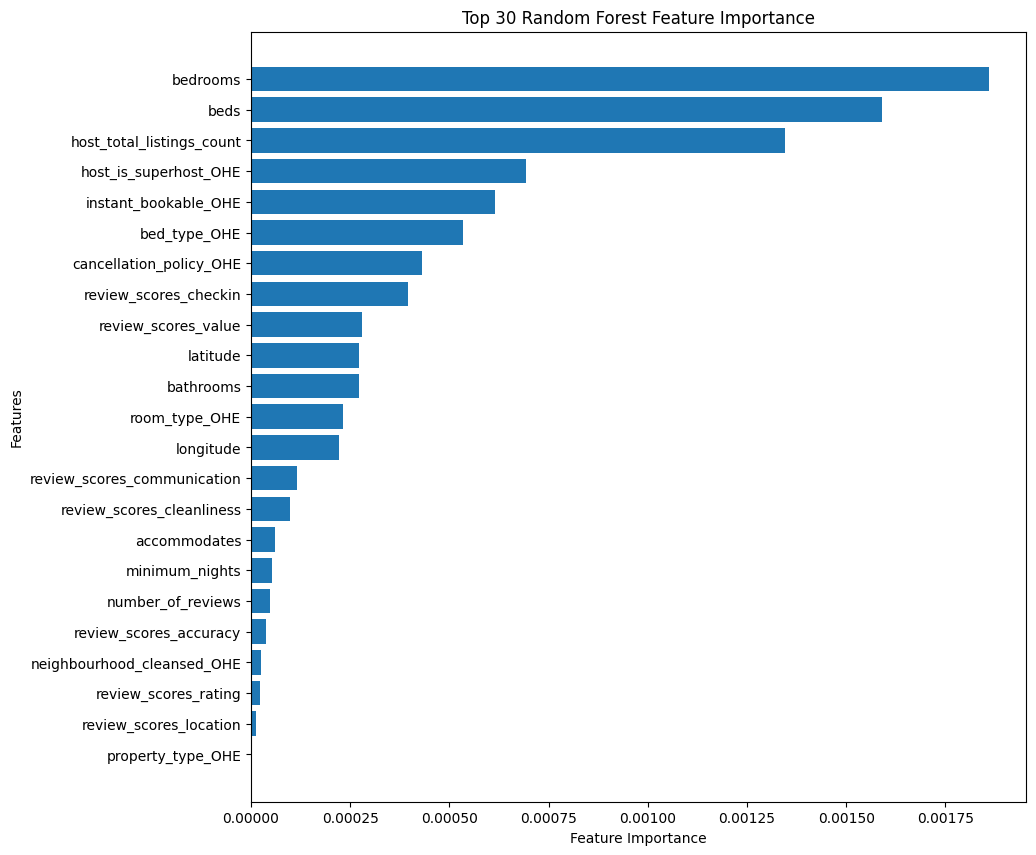

In [179]:
import matplotlib.pyplot as plt

feature_importance = pl_Model.stages[-1].featureImportances

feature_names = vecAssemb.getInputCols()

feature_importance_list = list(zip(feature_names, feature_importance))
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

top_features = feature_importance_list[:30]
sorted_feature_names = [x[0] for x in top_features]
sorted_importance_scores = [x[1] for x in top_features]

plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_importance_scores)), sorted_importance_scores, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 30 Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [181]:
traindf_with_features.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price',
 'host_total_listings_count_square',
 'host_total_listings_count_cube',
 'host_total_listings_count_plus_latitude',
 'host_total_listings_count_times_latitude',
 'host_total_listings_count_plus_longitude',
 'host_total_listings_count_times_longitude',
 'host_total_listings_count_plus_accommodates',
 'host_total_listings_count_times_accommodates',
 'host_total_listings_count_plus_bathrooms',
 'host_total_listings_count_times_bathrooms',
 'host_total_listings_count_plus_bedrooms',
 'host_total_listings_cou

In [180]:
dtypes=traindf_with_features.select(sorted_feature_names).dtypes
stringCols = [k for k,v in dtypes if v=='string']
stringColOut = [k+'_Index' for k,v in dtypes if v=='string']

OHEoutCol = [k+'_OHE' for k,v in dtypes if v=='string']
numericColsnew=[k for k,v in traindf_with_features[sorted_feature_names].dtypes if (v=='double' ) ]
#numericColsnew.remove('price')

allcolsnew=OHEoutCol+numericColsnew

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `host_is_superhost_OHE` cannot be resolved. Did you mean one of the following? [`host_is_superhost`, `beds_cube`, `beds_square`, `latitude`, `latitude_cube`].;
'Project [bedrooms#10031, beds#10032, host_total_listings_count#10023, 'host_is_superhost_OHE, 'instant_bookable_OHE, 'bed_type_OHE, 'cancellation_policy_OHE, review_scores_checkin#10039, review_scores_value#10042, latitude#10025, bathrooms#10030, 'room_type_OHE, longitude#10026, review_scores_communication#10040, review_scores_cleanliness#10038, accommodates#10029, minimum_nights#10034, number_of_reviews#10035, review_scores_accuracy#10037, 'neighbourhood_cleansed_OHE, review_scores_rating#10036, review_scores_location#10041, 'property_type_OHE]
+- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 272 more fields]
   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 271 more fields]
      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 270 more fields]
         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 269 more fields]
            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 268 more fields]
               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 267 more fields]
                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 266 more fields]
                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 265 more fields]
                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 264 more fields]
                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 263 more fields]
                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 262 more fields]
                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 261 more fields]
                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 260 more fields]
                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 259 more fields]
                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 258 more fields]
                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 257 more fields]
                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 256 more fields]
                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 255 more fields]
                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 254 more fields]
                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 253 more fields]
                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 252 more fields]
                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 251 more fields]
                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 250 more fields]
                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 249 more fields]
                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 248 more fields]
                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 247 more fields]
                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 246 more fields]
                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 245 more fields]
                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 244 more fields]
                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 243 more fields]
                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 242 more fields]
                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 241 more fields]
                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 240 more fields]
                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 239 more fields]
                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 238 more fields]
                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 237 more fields]
                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 236 more fields]
                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 235 more fields]
                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 234 more fields]
                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 233 more fields]
                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 232 more fields]
                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 231 more fields]
                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 230 more fields]
                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 229 more fields]
                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 228 more fields]
                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 227 more fields]
                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 226 more fields]
                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 225 more fields]
                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 224 more fields]
                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 223 more fields]
                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 222 more fields]
                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 221 more fields]
                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 220 more fields]
                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 219 more fields]
                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 218 more fields]
                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 217 more fields]
                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 216 more fields]
                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 215 more fields]
                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 214 more fields]
                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 213 more fields]
                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 212 more fields]
                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 211 more fields]
                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 210 more fields]
                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 209 more fields]
                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 208 more fields]
                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 207 more fields]
                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 206 more fields]
                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 205 more fields]
                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 204 more fields]
                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 203 more fields]
                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 202 more fields]
                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 201 more fields]
                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 200 more fields]
                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 199 more fields]
                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 198 more fields]
                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 197 more fields]
                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 196 more fields]
                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 195 more fields]
                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 194 more fields]
                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 193 more fields]
                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 192 more fields]
                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 191 more fields]
                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 190 more fields]
                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 189 more fields]
                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 188 more fields]
                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 187 more fields]
                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 186 more fields]
                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 185 more fields]
                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 184 more fields]
                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 183 more fields]
                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 182 more fields]
                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 181 more fields]
                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 180 more fields]
                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 179 more fields]
                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 178 more fields]
                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 177 more fields]
                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 176 more fields]
                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 175 more fields]
                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 174 more fields]
                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 173 more fields]
                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 172 more fields]
                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 171 more fields]
                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 170 more fields]
                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 169 more fields]
                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 168 more fields]
                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 167 more fields]
                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 166 more fields]
                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 165 more fields]
                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 164 more fields]
                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 163 more fields]
                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 162 more fields]
                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 161 more fields]
                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 160 more fields]
                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 159 more fields]
                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 158 more fields]
                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 157 more fields]
                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 156 more fields]
                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 155 more fields]
                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 154 more fields]
                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 153 more fields]
                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 152 more fields]
                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 151 more fields]
                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 150 more fields]
                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 149 more fields]
                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 148 more fields]
                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 147 more fields]
                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 146 more fields]
                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 145 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 144 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 143 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 142 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 141 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 140 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 139 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 138 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 137 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 136 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 135 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 134 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 133 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 132 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 131 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 130 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 129 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 128 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 127 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 126 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 125 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 124 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 123 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 122 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 121 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 120 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 119 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 118 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 117 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 116 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 115 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 114 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 113 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 112 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 111 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 110 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 109 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 108 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 107 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 106 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 105 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 104 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 103 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 102 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 101 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 100 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 99 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 98 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 97 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 96 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 95 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 94 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 93 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 92 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 91 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 90 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 89 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 88 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 87 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 86 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 85 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 84 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 83 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 82 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 81 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 80 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 79 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 78 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 77 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 76 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 75 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 74 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 73 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 72 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 71 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 70 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 69 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 68 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 67 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 66 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 65 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 64 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 63 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 62 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 61 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 60 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 59 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 58 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 57 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 56 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 55 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 54 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 53 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 52 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 51 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 50 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 49 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 48 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 47 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 46 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 45 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 44 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 43 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 42 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 41 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 40 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 39 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 38 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 37 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 36 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 35 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 34 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 33 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 32 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 31 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 30 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 29 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 28 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 27 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 26 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 25 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 24 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 23 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 22 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 21 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 20 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 19 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 18 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 17 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 16 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 15 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 14 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 13 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 12 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 11 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 10 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 9 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 8 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 7 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 6 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 5 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 4 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 3 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, ... 2 more fields]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             +- Project [host_is_superhost#10020, cancellation_policy#10021, instant_bookable#10022, host_total_listings_count#10023, neighbourhood_cleansed#10024, latitude#10025, longitude#10026, property_type#10027, room_type#10028, accommodates#10029, bathrooms#10030, bedrooms#10031, beds#10032, bed_type#10033, minimum_nights#10034, number_of_reviews#10035, review_scores_rating#10036, review_scores_accuracy#10037, review_scores_cleanliness#10038, review_scores_checkin#10039, review_scores_communication#10040, review_scores_location#10041, review_scores_value#10042, price#10043, POWER(host_total_listings_count#10023, cast(2 as double)) AS host_total_listings_count_square#256401]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                +- Relation [host_is_superhost#10020,cancellation_policy#10021,instant_bookable#10022,host_total_listings_count#10023,neighbourhood_cleansed#10024,latitude#10025,longitude#10026,property_type#10027,room_type#10028,accommodates#10029,bathrooms#10030,bedrooms#10031,beds#10032,bed_type#10033,minimum_nights#10034,number_of_reviews#10035,review_scores_rating#10036,review_scores_accuracy#10037,review_scores_cleanliness#10038,review_scores_checkin#10039,review_scores_communication#10040,review_scores_location#10041,review_scores_value#10042,price#10043] parquet


## Random forest with new features

In [ ]:
StrInd = StringIndexer(inputCols=stringCols,outputCols=stringColOut,handleInvalid='keep')
OHE = OneHotEncoder(inputCols=stringColOut,outputCols=OHEoutCol,handleInvalid='keep')

vecAssemb = VectorAssembler(inputCols=allcolsnew,outputCol='features',handleInvalid='keep')

In [182]:
#create the random forest object
rf=RandomForestRegressor(featuresCol='features',labelCol='price',predictionCol='prediction',numTrees=1000)
#define the stages for the pipeline
stages = [StrInd,OHE,vecAssemb,rf]
#creating the pipeline object
pl = Pipeline(stages=stages)
#fitting the pipeline to the training data
pl_Model = pl.fit(traindf_with_features)
pred_train = pl_Model.transform(traindf_with_features)
#finally transform on the test data
pred_test = pl_Model.transform(testdf_with_features)

In [183]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.17345271590825773

R_2 for test data 0.4781207529603596


In [184]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.622555547337185

R_2 for test data 0.6415114688272402


## XGBOOST

In [185]:
xgb_params = {
    "objective": "reg:squarederror",
    "num_round": 100,
    "max_depth": 6,
    "eta": 0.3,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "missing": float('inf')  
}
xgb_regressor = SparkXGBRegressor(
    features_col="features",
    label_col="price",
    prediction_col="prediction",
    num_workers=2,
    **xgb_params
)

stages = [StrInd, OHE, vecAssemb, xgb_regressor]
pipeline = Pipeline(stages=stages)

pl_Model = pipeline.fit(traindf_with_features)

pred_train = pl_Model.transform(traindf_with_features)

pred_test = pl_Model.transform(testdf_with_features)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 1.0, 'device': 'cpu', 'max_depth': 6, 'subsample': 1.0, 'num_round': 100, 'eta': 0.3, 'eval_metric': 'rmse', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': inf}
INFO:XGBoost-PySpark:Finished xgboost training!


In [186]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.8424039769198485

R_2 for test data 0.5557577964156026


In [187]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.9266495479371957

R_2 for test data 0.6980315094481251


### 1)

In [194]:
xgb_params = {
    "objective": "reg:squarederror",
    "num_round": 1000,
    "max_depth": 5,
    "eta": 0.3,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "eval_metric": "mae",
    "missing": float('inf'),
    "lambda": 1.0,
    "seed":42
}
xgb_regressor = SparkXGBRegressor(
    features_col="features",
    label_col="price",
    prediction_col="prediction",
    num_workers=2,
    **xgb_params
)

stages = [StrInd, OHE, vecAssemb, xgb_regressor]
pipeline = Pipeline(stages=stages)

pl_Model = pipeline.fit(traindf_with_features)

pred_train = pl_Model.transform(traindf_with_features)

pred_test = pl_Model.transform(testdf_with_features)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 1.0, 'device': 'cpu', 'max_depth': 5, 'subsample': 1.0, 'num_round': 1000, 'eta': 0.3, 'lambda': 1.0, 'seed': 42, 'eval_metric': 'mae', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': inf}
INFO:XGBoost-PySpark:Finished xgboost training!


In [195]:
pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.6292690800963722

R_2 for test data 0.5913703019408741


In [196]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.8817612386805839

R_2 for test data 0.7113603775048195


### 2)

In [230]:
xgb_params = {
    "objective": "reg:squarederror",
    "num_round": 2000,
    "max_depth": 4,
    "eta": 0.3,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "missing": float('inf'),
    "lambda": 100,
    "seed":42
}
xgb_regressor = SparkXGBRegressor(
    features_col="features",
    label_col="price",
    prediction_col="prediction",
    num_workers=2,
    **xgb_params
)

stages = [StrInd, OHE, vecAssemb, xgb_regressor]
pipeline = Pipeline(stages=stages)

pl_Model = pipeline.fit(traindf_with_features)

pred_train = pl_Model.transform(traindf_with_features)

pred_test = pl_Model.transform(testdf_with_features)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 1.0, 'device': 'cpu', 'max_depth': 4, 'subsample': 1.0, 'num_round': 2000, 'eta': 0.3, 'lambda': 100, 'seed': 42, 'eval_metric': 'rmse', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': inf}
INFO:XGBoost-PySpark:Finished xgboost training!


In [231]:

pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.2760549762967488

R_2 for test data 0.6477158242535772


In [232]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.7649758386457057

R_2 for test data 0.7420385306333219


### 3)

In [254]:
xgb_params = {
    "objective": "reg:squarederror",
    "num_round": 2000,
    "max_depth": 4,
    "eta": 0.3,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "missing": float('inf'),
    "alpha":2,
    "lambda":10,
    "seed":42
}
xgb_regressor = SparkXGBRegressor(
    features_col="features",
    label_col="price",
    prediction_col="prediction",
    num_workers=2,
    **xgb_params
)

stages = [StrInd, OHE, vecAssemb, xgb_regressor]
pipeline = Pipeline(stages=stages)

pl_Model = pipeline.fit(traindf_with_features)

pred_train = pl_Model.transform(traindf_with_features)

pred_test = pl_Model.transform(testdf_with_features)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 1.0, 'device': 'cpu', 'max_depth': 4, 'subsample': 1.0, 'num_round': 2000, 'eta': 0.3, 'alpha': 2, 'lambda': 10, 'seed': 42, 'eval_metric': 'rmse', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': inf}
INFO:XGBoost-PySpark:Finished xgboost training!


In [255]:

pred_train=pred_train.withColumn('exp_price',exp(pred_train['price']))\
                      .withColumn('exp_prediction',exp(pred_train['prediction']))
pred_test=pred_test.withColumn('exp_price',exp(pred_test['price']))\
                      .withColumn('exp_prediction',exp(pred_test['prediction']))
r2 = RegressionEvaluator(predictionCol='exp_prediction',labelCol='exp_price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.33758596927969964

R_2 for test data 0.6350711801310541


In [256]:
r2 = RegressionEvaluator(predictionCol='prediction',labelCol='price',metricName='r2')
print(f'R_2 for train data {r2.evaluate(pred_train)}\n')
print(f'R_2 for test data {r2.evaluate(pred_test)}')

R_2 for train data 0.8003362557175643

R_2 for test data 0.7377618852648791


**Adaboost**

In [221]:
!python -m pip install synapseml==${}


/bin/bash: line 1: synapseml==${}: bad substitution


# Feature Engineering

In [ ]:
traindf.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price']

In [ ]:
traindf.show(10)

+-----------------+-------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+-------------------+--------+--------------------+-------------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+------------------+
|host_is_superhost|cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude| longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|               beds|bed_type|      minimum_nights|  number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|review_scores_value|             price|
+-----------------+-------------------+----------------+-------------------------+----------------------+--------+------

In [ ]:
#!pip install feature_engine

ERROR: Operation cancelled by user


In [ ]:
'''from feature_engine.encoding import MeanEncoder
meanencoder=MeanEncoder(variables=['neighbourhood_cleansed','property_type'])
meanencoder.fit(traindf,traindf['price'])'''

"from feature_engine.encoding import MeanEncoder\nmeanencoder=MeanEncoder(variables=['neighbourhood_cleansed','property_type'])\nmeanencoder.fit(traindf,traindf['price'])"

In [ ]:
'''dtypes=traindf.dtypes
stringCols = [k for k,v in dtypes if v=='string']
stringColOut = [k+'_Index' for k,v in dtypes if v=='string']
OHEoutCol = [k+'_OHE' for k,v in dtypes if v=='string']
numericCols = [k for k,v in dtypes if ((v=='double')&(k!='price'))]
allCol = OHEoutCol + numericCols
allCol'''

* since we couldn't find a way to use ordinal encoding and target encoding in pyspark
* we can use onehot encoding besides hash encoding for categorical features with high cardinality

In [ ]:
#one hot
#host_is_superhost          instant_bookable
#hash encoding
#cancellation_policy            room_type             bed_type
#neighbourhood_cleansed         property_type

In [ ]:
stringCols = [k for k,v in dtypes if v=='string']
stringColOut = [k+'_Index' for k,v in dtypes if v=='string']
OHEcols=['host_is_superhost'   ,       'instant_bookable'   ]
OHEoutCol = ['host_is_superhost_OHE'   ,       'instant_bookable_OHE'   ]
hashcols=['cancellation_policy','room_type','bed_type','neighbourhood_cleansed'       ,  'property_type']
hashOutcols=[]

numericCols = [k for k,v in df_dropped2.dtypes if ((v=='double')&(k!='price'))]

allcols=OHEoutCol+hashOutcols+numericCols

In [ ]:
StrInd = StringIndexer(inputCols=stringCols,outputCols=stringColOut,handleInvalid='keep')
OHE = OneHotEncoder(inputCols=stringColOut,outputCols=OHEoutCol)
hasher=FeatureHasher(inputCols=['host_is_superhost'   ,       'instant_bookable'   ], outputCol=['host_is_superhost_OHE'   ,       'instant_bookable_OHE'   ])
vecAssemb = VectorAssembler(inputCols=allCol,outputCol='features')

TypeError: Invalid param value given for param "outputCol". Could not convert <class 'list'> to string type